### PyTorch implementation of the RIM paper (Recurrent Independent Mechanism)

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import math 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from rim import RIMNetwork,RIMNetwork_specialized,RIMNetwork_specialized_multHead,RIMNetwork_multHead

def compress_labels(labels):
    new_labels = np.zeros_like(labels)
    for i in range(labels.shape[0]):
        prev_val = 0
        for j in range(labels.shape[1]):
            curr_val = labels[i,j]
            if curr_val != 0 and curr_val == prev_val:
                new_labels[i,j] = 0
            else:
                new_labels[i,j] = curr_val
                if j+1 < labels.shape[1]:
                    new_labels[i,j+1] = 1 # oopas???
            prev_val = curr_val
    return new_labels


def compress_labels(labels):
    new_labels = np.zeros_like(labels)
    for i in range(labels.shape[0]):
        prev_val = 0
        repeat_count = 0
        for j in range(labels.shape[1]):
            curr_val = labels[i,j]
            if curr_val != 0 and curr_val == prev_val:
                repeat_count += 1
                if repeat_count >= 2:  # After two occurrences, start zeroing out
                    new_labels[i,j] = 0
                else:
                    new_labels[i,j] = curr_val
            else:
                new_labels[i,j] = curr_val
                repeat_count = 0
            prev_val = curr_val
    return new_labels

### Multitask training

In [28]:
from torch.utils.data import Dataset, DataLoader
import matplotlib.font_manager
from neurogym import Dataset
from Mod_Cog.mod_cog_tasks import *
from matplotlib import rcParams
rcParams['font.sans-serif'] = "ubuntu"
rcParams['font.family'] = "ubuntu"

In [29]:
envs_simple = [go(), rtgo(), dlygo(), anti(), rtanti(), dlyanti(),
                dm1(), dm2(), ctxdm1(), ctxdm2(), multidm(), 
                dlydm1(), dlydm2(), ctxdlydm1(), ctxdlydm2(), multidlydm(), 
                dms(), dnms(), dmc(), dnmc()]

# envs_simple = [go(), rtgo(), dlygo(), anti(), rtanti(), dlyanti(),ctxdm1(), ctxdm2()]

schedule = RandomSchedule(len(envs_simple))
env = ScheduleEnvs(envs_simple, schedule=schedule, env_input=True)

# iterable dataset from which it is possible to draw samples
dataset = Dataset(env, batch_size=64, seq_len=100)
ob_size = env.observation_space.shape[0]
act_size = env.action_space.n

print('obs size', ob_size, 'act_size', act_size)

# To draw samples, use neurogym's dataset class:
inputs, labels = dataset()
print('inputs', inputs.shape, 'labels', labels.shape)

obs size 53 act_size 17
inputs (100, 64, 53) labels (100, 64)


In [30]:
batch_size = 64
hidden_size = 64
learning_rate = 0.001
num_epochs = 50

input_size = ob_size
output_size = act_size

num_mechanisms = 3
key_size = 2
rank = 2
num_heads = 1


model = RIMNetwork_multHead(input_size, hidden_size, output_size, num_mechanisms=num_mechanisms,
                key_size=key_size, rank=rank, num_heads=num_heads,task_size=len(envs_simple)).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 39953


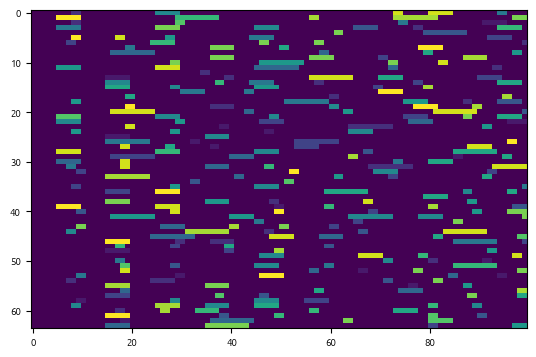

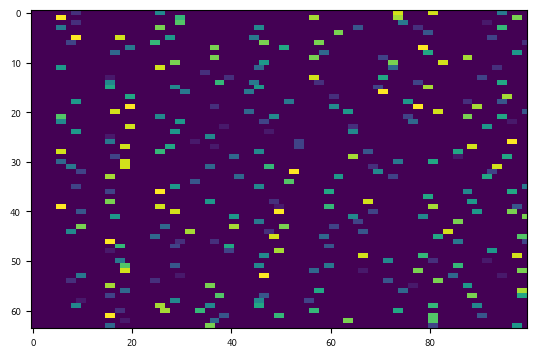

In [31]:
inputs, labels = dataset()
labels = np.transpose(labels, (1, 0))
plt.figure()
plt.imshow(labels)
plt.show()
labels_compressed = compress_labels(labels)
plt.figure()
plt.imshow(labels_compressed)
plt.show()

In [33]:
losss = []
loss_moving_average = 0
# Training Loop
num_training_steps = 5000
for i_step in tqdm(range(num_training_steps)):

        # To draw samples, use neurogym's dataset class:
        inputs, labels = dataset()
        labels = compress_labels(labels)

        fixation_mask_npy = inputs[:,:,0] > 0  # Shape: [100, 64]
        fixation_mask = torch.tensor(fixation_mask).to(device)

        inputs = np.transpose(inputs, (1, 0, 2))
        labels = np.transpose(labels, (1, 0))

        outputs_total,_,_,_,attention_weights = model(torch.tensor(inputs,dtype=torch.float).to(device))

        outputs_reshaped = outputs_total.permute(1, 0, 2)  # Reshape to [100, 64, 17]

        criterion = nn.CrossEntropyLoss() # ignore_index=0)
        
        base_loss = criterion(outputs_total.reshape(-1,act_size), torch.tensor(labels).to(device).reshape(-1))

        compressed_activation = compress_labels(~fixation_mask_npy.T)
        compressed_activation   = torch.tensor(compressed_activation).to(device).T
        active_mask = ~compressed_activation.reshape(-1)
        masked_loss = base_loss

        # Add fixation penalty
        fixation_penalty = outputs_reshaped[fixation_mask].pow(2).mean()

        # we add a penality for the size of attention weights
        n_att_weights = attention_weights.numel()
        loss_attention = torch.sum(torch.abs(attention_weights)) / n_att_weights

        total_loss = masked_loss  + 0.1 * fixation_penalty + 0.1*loss_attention

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # loss moving average
        loss_moving_average = 0.99 * loss_moving_average + 0.01 * total_loss.item()
        losss.append(loss_moving_average)

        mask = labels > 0
        output_max = np.argmax(outputs_total.detach().cpu().numpy(),axis=2)
        accuracy = np.sum((output_max==labels)*mask)/ np.sum(mask)


        if i_step % 100 == 0:
            print(f'Step [{i_step}/{num_training_steps}], Loss: {total_loss.item()}')
            print('accuracy',accuracy)


  0%|          | 0/5000 [00:00<?, ?it/s]/tmp/ipykernel_528801/691184499.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fixation_mask = torch.tensor(fixation_mask).to(device)
  0%|          | 1/5000 [00:00<45:07,  1.85it/s]

Step [0/5000], Loss: 3.0547468662261963
accuracy 0.027135678391959798


  2%|▏         | 101/5000 [00:51<41:58,  1.95it/s]

Step [100/5000], Loss: 0.7980892062187195
accuracy 0.0


  4%|▍         | 201/5000 [01:39<38:38,  2.07it/s]

Step [200/5000], Loss: 0.7370314598083496
accuracy 0.015682656826568265


  6%|▌         | 301/5000 [02:28<38:16,  2.05it/s]

Step [300/5000], Loss: 0.7062100768089294
accuracy 0.09126984126984126


  8%|▊         | 401/5000 [03:18<38:27,  1.99it/s]

Step [400/5000], Loss: 0.6964573860168457
accuracy 0.16785079928952043


 10%|█         | 501/5000 [04:07<36:22,  2.06it/s]

Step [500/5000], Loss: 0.6055511832237244
accuracy 0.2787212787212787


 12%|█▏        | 601/5000 [04:56<36:20,  2.02it/s]

Step [600/5000], Loss: 0.5807015895843506
accuracy 0.4411492122335496


 14%|█▍        | 701/5000 [05:47<35:53,  2.00it/s]

Step [700/5000], Loss: 0.551259458065033
accuracy 0.5386554621848739


 16%|█▌        | 801/5000 [06:38<35:15,  1.99it/s]

Step [800/5000], Loss: 0.504417896270752
accuracy 0.6039510818438382


 18%|█▊        | 901/5000 [07:28<34:06,  2.00it/s]

Step [900/5000], Loss: 0.47702595591545105
accuracy 0.6401124648547329


 20%|██        | 1001/5000 [08:16<32:00,  2.08it/s]

Step [1000/5000], Loss: 0.46638813614845276
accuracy 0.6494464944649446


 22%|██▏       | 1101/5000 [09:06<33:22,  1.95it/s]

Step [1100/5000], Loss: 0.45670267939567566
accuracy 0.6725317693059628


 24%|██▍       | 1201/5000 [09:58<33:10,  1.91it/s]

Step [1200/5000], Loss: 0.4556584656238556
accuracy 0.6878504672897197


 26%|██▌       | 1301/5000 [10:51<31:21,  1.97it/s]

Step [1300/5000], Loss: 0.4396360218524933
accuracy 0.7277829747427502


 28%|██▊       | 1401/5000 [11:42<30:21,  1.98it/s]

Step [1400/5000], Loss: 0.4281165897846222
accuracy 0.7295597484276729


 30%|███       | 1501/5000 [12:34<30:21,  1.92it/s]

Step [1500/5000], Loss: 0.4174588620662689
accuracy 0.7334649555774926


 32%|███▏      | 1601/5000 [13:25<28:16,  2.00it/s]

Step [1600/5000], Loss: 0.42770084738731384
accuracy 0.7006610009442871


 34%|███▍      | 1701/5000 [14:16<28:00,  1.96it/s]

Step [1700/5000], Loss: 0.41412657499313354
accuracy 0.7396883593033914


 36%|███▌      | 1801/5000 [15:06<25:02,  2.13it/s]

Step [1800/5000], Loss: 0.3974980413913727
accuracy 0.7555762081784386


 38%|███▊      | 1901/5000 [15:54<23:39,  2.18it/s]

Step [1900/5000], Loss: 0.40709400177001953
accuracy 0.7610619469026548


 40%|████      | 2001/5000 [16:43<24:12,  2.06it/s]

Step [2000/5000], Loss: 0.3941485583782196
accuracy 0.7481343283582089


 42%|████▏     | 2101/5000 [17:32<25:52,  1.87it/s]

Step [2100/5000], Loss: 0.39674633741378784
accuracy 0.7953110910730388


 44%|████▍     | 2201/5000 [18:25<24:46,  1.88it/s]

Step [2200/5000], Loss: 0.3895812928676605
accuracy 0.7934224049331963


 46%|████▌     | 2301/5000 [19:16<25:15,  1.78it/s]

Step [2300/5000], Loss: 0.39639654755592346
accuracy 0.8294062205466541


 48%|████▊     | 2401/5000 [20:08<21:40,  2.00it/s]

Step [2400/5000], Loss: 0.3841980993747711
accuracy 0.7758784425451092


 50%|█████     | 2501/5000 [21:01<22:56,  1.82it/s]

Step [2500/5000], Loss: 0.39041540026664734
accuracy 0.779


 52%|█████▏    | 2601/5000 [21:53<20:59,  1.90it/s]

Step [2600/5000], Loss: 0.3794448971748352
accuracy 0.8545618789521229


 54%|█████▍    | 2701/5000 [22:45<19:39,  1.95it/s]

Step [2700/5000], Loss: 0.4015601575374603
accuracy 0.7301006404391582


 56%|█████▌    | 2801/5000 [23:35<19:23,  1.89it/s]

Step [2800/5000], Loss: 0.37700340151786804
accuracy 0.8203883495145631


 58%|█████▊    | 2901/5000 [24:28<18:21,  1.91it/s]

Step [2900/5000], Loss: 0.36973345279693604
accuracy 0.8042430086788814


 60%|██████    | 3001/5000 [25:20<15:55,  2.09it/s]

Step [3000/5000], Loss: 0.38096708059310913
accuracy 0.7679611650485437


 62%|██████▏   | 3101/5000 [26:10<16:03,  1.97it/s]

Step [3100/5000], Loss: 0.3758688271045685
accuracy 0.7540514775977121


 64%|██████▍   | 3201/5000 [27:01<15:40,  1.91it/s]

Step [3200/5000], Loss: 0.3747000992298126
accuracy 0.7955390334572491


 66%|██████▌   | 3301/5000 [27:52<14:22,  1.97it/s]

Step [3300/5000], Loss: 0.3921952545642853
accuracy 0.74408014571949


 68%|██████▊   | 3401/5000 [28:44<13:13,  2.01it/s]

Step [3400/5000], Loss: 0.36724308133125305
accuracy 0.8021295474711624


 70%|███████   | 3501/5000 [29:35<12:47,  1.95it/s]

Step [3500/5000], Loss: 0.37885311245918274
accuracy 0.7795555555555556


 72%|███████▏  | 3601/5000 [30:28<12:03,  1.93it/s]

Step [3600/5000], Loss: 0.3735898733139038
accuracy 0.8146754468485419


 74%|███████▍  | 3701/5000 [31:21<11:02,  1.96it/s]

Step [3700/5000], Loss: 0.36418798565864563
accuracy 0.8287292817679558


 76%|███████▌  | 3801/5000 [32:12<10:34,  1.89it/s]

Step [3800/5000], Loss: 0.3653619885444641
accuracy 0.7784371909000989


 78%|███████▊  | 3901/5000 [33:05<10:01,  1.83it/s]

Step [3900/5000], Loss: 0.36059287190437317
accuracy 0.8188331627430911


 80%|████████  | 4001/5000 [34:00<08:33,  1.94it/s]

Step [4000/5000], Loss: 0.35613107681274414
accuracy 0.8390243902439024


 82%|████████▏ | 4101/5000 [34:55<08:43,  1.72it/s]

Step [4100/5000], Loss: 0.35922861099243164
accuracy 0.7973657548125633


 84%|████████▍ | 4201/5000 [35:49<07:06,  1.87it/s]

Step [4200/5000], Loss: 0.3391364812850952
accuracy 0.867595818815331


 86%|████████▌ | 4301/5000 [36:42<06:19,  1.84it/s]

Step [4300/5000], Loss: 0.3590273857116699
accuracy 0.8212512413108243


 88%|████████▊ | 4401/5000 [37:34<05:05,  1.96it/s]

Step [4400/5000], Loss: 0.3490925133228302
accuracy 0.8454636091724825


 90%|█████████ | 4501/5000 [38:27<04:20,  1.91it/s]

Step [4500/5000], Loss: 0.3532465696334839
accuracy 0.8476104598737602


 92%|█████████▏| 4601/5000 [39:19<03:22,  1.97it/s]

Step [4600/5000], Loss: 0.34430840611457825
accuracy 0.8486238532110092


 94%|█████████▍| 4701/5000 [40:11<02:34,  1.94it/s]

Step [4700/5000], Loss: 0.34285834431648254
accuracy 0.82483781278962


 96%|█████████▌| 4801/5000 [41:02<01:37,  2.04it/s]

Step [4800/5000], Loss: 0.34579795598983765
accuracy 0.8269565217391305


 98%|█████████▊| 4901/5000 [41:52<00:48,  2.03it/s]

Step [4900/5000], Loss: 0.337643563747406
accuracy 0.8861788617886179


100%|██████████| 5000/5000 [42:42<00:00,  1.95it/s]


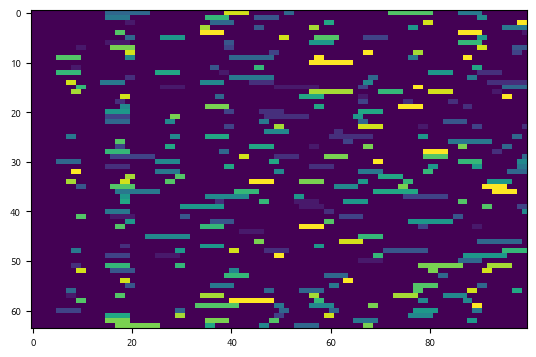

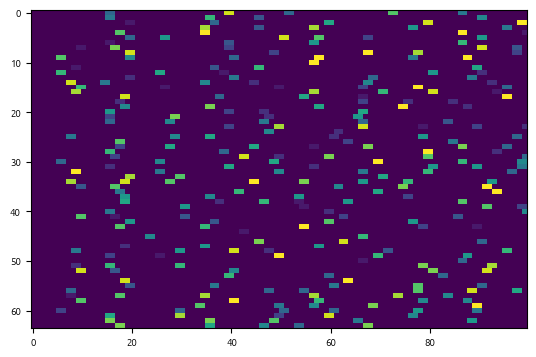

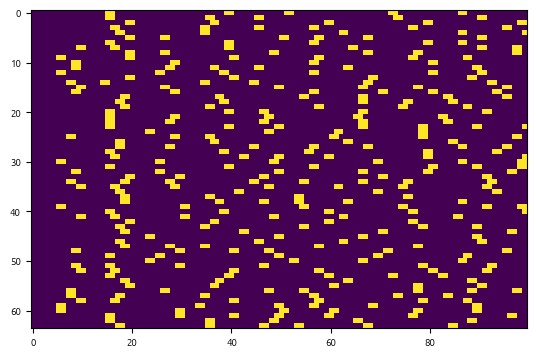

In [23]:

inputs, labels = dataset()
labels = np.transpose(labels, (1, 0))
plt.figure()
plt.imshow(labels)
plt.show()
labels_compressed = compress_labels(labels)
plt.figure()
plt.imshow(labels_compressed)
plt.show()

fixation_mask = inputs[:,:,0] > 0  # Shape: [100, 64]
fixation_mask = torch.tensor(fixation_mask).to(device)

compressed_fixation = compress_labels((~fixation_mask).cpu().numpy().T)
plt.figure()
plt.imshow(compressed_fixation)
plt.show()

In [21]:
active_mask.shape

torch.Size([6400])

In [7]:
#save the model
save = True

if save:

    name = "model_rim_12_mono"
    
    torch.save(model.state_dict(), 'saved_models/'+name+'.pth')

    # save the parameters
    parameters = {'input_size': input_size,
                'hidden_size': hidden_size,
                'output_size': output_size,
                'num_mechanisms': num_mechanisms,
                'key_size': key_size,
                'rank': rank,
                'num_heads': num_heads}
    # yaml
    import yaml
    with open('saved_models/'+name+'.yaml', 'w') as file:
        documents = yaml.dump(parameters, file)

In [8]:
fixation_mask.shape

torch.Size([100, 64])